In [105]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import joblib
import csv

In [50]:
#Function
def preprocess(input_data,label_data):
    data = pd.read_csv(input_data, sep='\t')
    label = pd.read_csv(label_data, sep='\t')
    X = data.iloc[:, 4:]
    le = LabelEncoder()
    label['Subgroup_encoded'] = le.fit_transform(label['Subgroup'])
    y = np.array(label['Subgroup_encoded'])
    return X.T,y

def preprocess_s(input_data,label_data):
    data = pd.read_csv(input_data,index_col=0, sep=',')
    label = pd.read_csv(label_data, sep='\t')
    le = LabelEncoder()
    label['Subgroup_encoded'] = le.fit_transform(label['Subgroup'])
    y = np.array(label['Subgroup_encoded'])
    x = data.drop(data.columns[-1], axis=1)
    return x,y

def RFECV_and_plot(data,label,model):
    rfecv = RFECV(estimator=xgb, step=1, cv=StratifiedKFold(5), scoring='accuracy')
    rfecv.fit(data, label)
    print("Optimal number of features : %d" % rfecv.n_features_)
    cv_scores = rfecv.cv_results_['mean_test_score']
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross-validation score (nb of correct classifications)")
    plt.plot(range(1, len(cv_scores) + 1), cv_scores)
    plt.title("RFECV - Optimization of Number of Features")
    plt.show()
    return rfecv

def Nested_cv_random(X,Y,input_classifier,search=False):
    param_distributions = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.001, 0.003, 0.01, 0.03, 0.1, 0.2, 0.3],
        'n_estimators': [100, 200, 300],
        'subsample': [0.8, 1]}
    
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    nested_accuracy = []
    nested_f1 = []
    nested_recall = []
    nested_prediction = []
    best_models = []
    
    cumulative_cm = np.zeros((len(np.unique(y)), len(np.unique(y))))
    
    for train_index, test_index in outer_cv.split(x, y):
    
        X_train, X_test = x.iloc[train_index,], x.iloc[test_index,]
        y_train, y_test = y[train_index], y[test_index]
    
        #model = RandomizedSearchCV(
        if search:
            model = RandomizedSearchCV(
                input_classifier, 
                param_distributions, 
                cv=inner_cv, 
                n_jobs=8
                #random_state=42
            )
        else:
            model = input_classifier
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        precision = precision_score(y_test,y_pred,average='macro')
        
        nested_accuracy.append(accuracy)
        nested_f1.append(f1)
        nested_recall.append(recall)
        nested_prediction.append(precision)
        
        if search:
            best_models.append(model.best_estimator_)
        else:
            best_models.append(model)
    
        cm = confusion_matrix(y_test, y_pred)
        cumulative_cm += cm
        print(f"Confusion Matrix for fold:\n{cm}\n")
    
    mean_accuracy = np.mean(nested_accuracy)
    std_accuracy = np.std(nested_accuracy)
    
    mean_f1 = np.mean(nested_f1)
    std_f1 = np.std(nested_f1)
    
    mean_recall = np.mean(nested_recall)
    std_recall = np.std(nested_recall)
    
    mean_precision = np.mean(nested_prediction)
    std_precision = np.std(nested_prediction)
    
    print(f"The mean accuracy using nested cross-validation is: {mean_accuracy:.3f} ± {std_accuracy:.3f}")
    print(f"The mean F1 score using nested cross-validation is: {mean_f1:.3f} ± {std_f1:.3f}")
    print(f"The mean recall using nested cross-validation is: {mean_recall:.3f} ± {std_recall:.3f}")
    print(f"The mean precision using nested cross-validation is: {mean_precision:.3f} ± {std_precision:.3f}")
    
    best_model_index = np.argmax(nested_f1) 
    best_model = best_models[best_model_index]
    
    print("Best Model:", best_model)
    print("Best Parameters:", best_model.get_params())
    
    plt.figure(figsize=(4, 3))
    sns.heatmap(cumulative_cm, annot=True, cmap='coolwarm', xticklabels=["HER2+", "HR+", "Triple Neg"], yticklabels=["HER2+", "HR+", "Triple Neg"])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


#1.RawFeature

Confusion Matrix for fold:
[[7 0 0]
 [0 7 0]
 [0 5 1]]
Confusion Matrix for fold:
[[7 0 0]
 [0 6 1]
 [0 4 2]]
Confusion Matrix for fold:
[[6 0 0]
 [0 5 3]
 [0 3 3]]
Confusion Matrix for fold:
[[6 0 0]
 [0 7 0]
 [0 1 6]]
Confusion Matrix for fold:
[[6 0 0]
 [0 6 1]
 [0 2 5]]

The mean accuracy using nested cross-validation is: 0.800 ± 0.089
The mean F1 score using nested cross-validation is: 0.782 ± 0.106
The mean recall using nested cross-validation is: 0.794 ± 0.096
The mean precision using nested cross-validation is: 0.829 ± 0.088
Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_

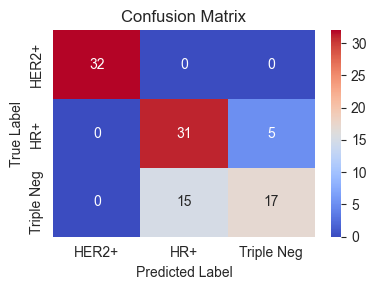

In [56]:
#Random search-parameter
x,y = preprocess(input_data='/Users/crystal_zhao/Desktop/B4TM/data/Train_call.txt',
                 label_data='/Users/crystal_zhao/Desktop/B4TM/data/Train_clinical.txt')
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss') 
final_model = Nested_cv_random(x,y,xgb,search=True)

Confusion Matrix for fold:
[[7 0 0]
 [0 7 0]
 [0 4 2]]
Confusion Matrix for fold:
[[7 0 0]
 [0 4 3]
 [0 3 3]]
Confusion Matrix for fold:
[[6 0 0]
 [0 5 3]
 [0 1 5]]
Confusion Matrix for fold:
[[6 0 0]
 [0 6 1]
 [0 0 7]]
Confusion Matrix for fold:
[[6 0 0]
 [0 6 1]
 [0 3 4]]

The mean accuracy using nested cross-validation is: 0.810 ± 0.080
The mean F1 score using nested cross-validation is: 0.803 ± 0.086
The mean recall using nested cross-validation is: 0.810 ± 0.084
The mean precision using nested cross-validation is: 0.834 ± 0.088
Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat

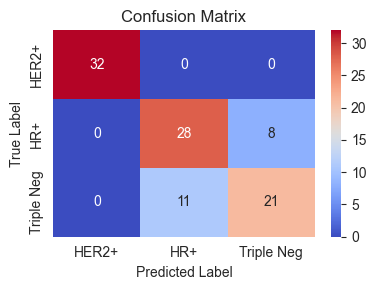

In [42]:
#Default-parameter
x,y = preprocess(input_data='/Users/crystal_zhao/Desktop/B4TM/data/Train_call.txt',
                 label_data='/Users/crystal_zhao/Desktop/B4TM/data/Train_clinical.txt')
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss') 
Nested_cv_random(x,y,xgb)

#2.REFCV feature

Optimal number of features : 41


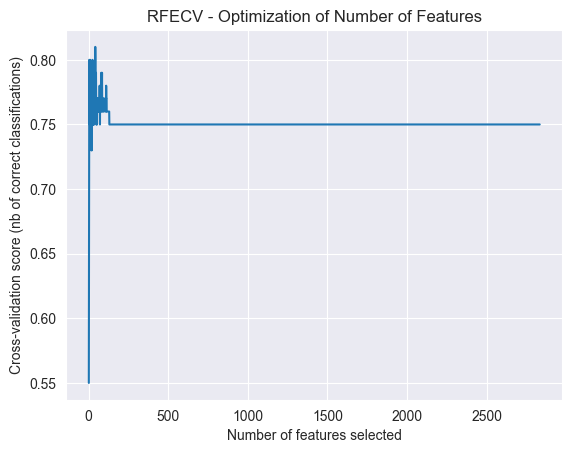

In [43]:
x,y = preprocess(input_data='/Users/crystal_zhao/Desktop/B4TM/data/Train_call.txt',
                 label_data='/Users/crystal_zhao/Desktop/B4TM/data/Train_clinical.txt')
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss') 

rfecv = RFECV_and_plot(x,y,xgb)
subset_x = x.iloc[:,rfecv.support_]

Confusion Matrix for fold:
[[7 0 0]
 [0 7 0]
 [0 4 2]]
Confusion Matrix for fold:
[[7 0 0]
 [0 7 0]
 [0 4 2]]
Confusion Matrix for fold:
[[6 0 0]
 [0 5 3]
 [0 1 5]]
Confusion Matrix for fold:
[[6 0 0]
 [0 7 0]
 [0 1 6]]
Confusion Matrix for fold:
[[6 0 0]
 [0 6 1]
 [0 2 5]]

The mean accuracy using nested cross-validation is: 0.840 ± 0.058
The mean F1 score using nested cross-validation is: 0.827 ± 0.072
The mean recall using nested cross-validation is: 0.837 ± 0.065
The mean precision using nested cross-validation is: 0.879 ± 0.045
Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat

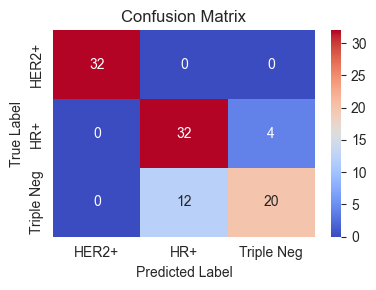

In [44]:
#Random search-parameter
Nested_cv_random(subset_x,y,xgb,search=True)

Confusion Matrix for fold:
[[7 0 0]
 [0 7 0]
 [0 4 2]]
Confusion Matrix for fold:
[[7 0 0]
 [0 4 3]
 [0 3 3]]
Confusion Matrix for fold:
[[6 0 0]
 [0 5 3]
 [0 1 5]]
Confusion Matrix for fold:
[[6 0 0]
 [0 6 1]
 [0 0 7]]
Confusion Matrix for fold:
[[6 0 0]
 [0 6 1]
 [0 3 4]]

The mean accuracy using nested cross-validation is: 0.810 ± 0.080
The mean F1 score using nested cross-validation is: 0.803 ± 0.086
The mean recall using nested cross-validation is: 0.810 ± 0.084
The mean precision using nested cross-validation is: 0.834 ± 0.088
Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat

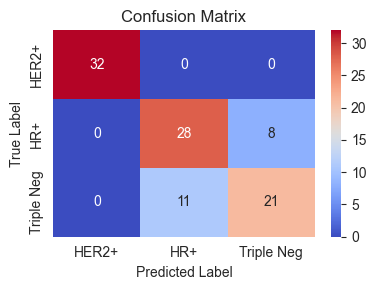

In [45]:
#Default-parameter 
Nested_cv_random(subset_x,y,xgb)

#3.ANOVA feature

Confusion Matrix for fold:
[[3 3 1]
 [2 5 0]
 [2 2 2]]
Confusion Matrix for fold:
[[5 2 0]
 [1 6 0]
 [5 0 1]]
Confusion Matrix for fold:
[[5 1 0]
 [0 6 2]
 [1 0 5]]
Confusion Matrix for fold:
[[4 1 1]
 [2 5 0]
 [0 0 7]]
Confusion Matrix for fold:
[[4 0 2]
 [1 5 1]
 [1 1 5]]

The mean accuracy using nested cross-validation is: 0.680 ± 0.117
The mean F1 score using nested cross-validation is: 0.665 ± 0.127
The mean recall using nested cross-validation is: 0.674 ± 0.122
The mean precision using nested cross-validation is: 0.714 ± 0.097
Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_

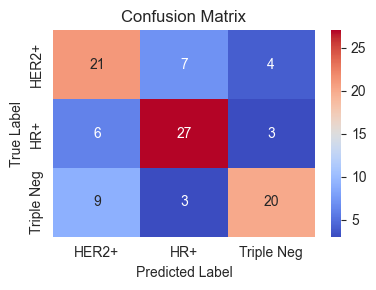

In [46]:
#Random search-parameter
x,y = preprocess(input_data='/Users/crystal_zhao/Desktop/B4TM/data/Train_call_anovaselected.txt',
                 label_data='/Users/crystal_zhao/Desktop/B4TM/data/Train_clinical.txt')
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss') 
Nested_cv_random(x,y,xgb,search=True)

Confusion Matrix for fold:
[[3 3 1]
 [1 6 0]
 [2 2 2]]

Confusion Matrix for fold:
[[5 1 1]
 [2 5 0]
 [5 0 1]]
Confusion Matrix for fold:
[[4 2 0]
 [1 6 1]
 [1 0 5]]
Confusion Matrix for fold:
[[2 1 3]
 [3 4 0]
 [0 0 7]]
Confusion Matrix for fold:
[[4 0 2]
 [1 6 0]
 [3 0 4]]

The mean accuracy using nested cross-validation is: 0.640 ± 0.080
The mean F1 score using nested cross-validation is: 0.622 ± 0.094
The mean recall using nested cross-validation is: 0.631 ± 0.086
The mean precision using nested cross-validation is: 0.652 ± 0.072
Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_ca

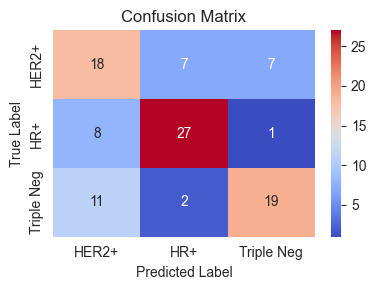

In [47]:
#Default-parameter
Nested_cv_random(x,y,xgb)

#4. RF feature

Confusion Matrix for fold:
[[7 0 0]
 [0 7 0]
 [0 4 2]]
Confusion Matrix for fold:
[[7 0 0]
 [0 6 1]
 [0 3 3]]
Confusion Matrix for fold:
[[6 0 0]
 [0 5 3]
 [0 1 5]]
Confusion Matrix for fold:
[[6 0 0]
 [0 6 1]
 [0 2 5]]
Confusion Matrix for fold:
[[6 0 0]
 [0 6 1]
 [0 2 5]]

The mean accuracy using nested cross-validation is: 0.820 ± 0.024
The mean F1 score using nested cross-validation is: 0.813 ± 0.039
The mean recall using nested cross-validation is: 0.819 ± 0.034
The mean precision using nested cross-validation is: 0.845 ± 0.028
Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_

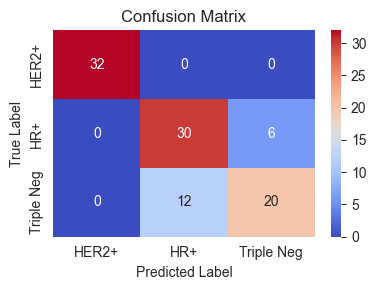

In [48]:
#Random search-paramter
x,y = preprocess_s(input_data='/Users/crystal_zhao/Desktop/B4TM/data/df_dt_excluded.txt',
                 label_data='/Users/crystal_zhao/Desktop/B4TM/data/Train_clinical.txt')
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss') 
Nested_cv_random(x,y,xgb,search=True)

Confusion Matrix for fold:
[[7 0 0]
 [0 7 0]
 [0 4 2]]
Confusion Matrix for fold:
[[7 0 0]
 [0 4 3]
 [0 3 3]]
Confusion Matrix for fold:
[[6 0 0]
 [0 5 3]
 [0 1 5]]
Confusion Matrix for fold:
[[6 0 0]
 [0 6 1]
 [0 2 5]]
Confusion Matrix for fold:
[[6 0 0]
 [0 6 1]
 [0 4 3]]

The mean accuracy using nested cross-validation is: 0.780 ± 0.051
The mean F1 score using nested cross-validation is: 0.773 ± 0.056
The mean recall using nested cross-validation is: 0.781 ± 0.056
The mean precision using nested cross-validation is: 0.807 ± 0.067
Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat

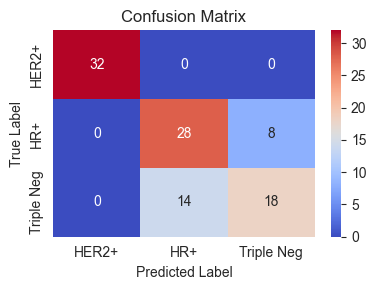

In [49]:
#Default-parameter
Nested_cv_random(x,y,xgb)